# TimeGAN implementation

In [42]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error

In [43]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [44]:
###############################################################################
# 1) Utilities: batch generator, min-max scaling
###############################################################################

def batch_generator(data, batch_size):
    """
    Randomly samples a subset of data (batch_size)
    """
    idx = np.random.permutation(len(data))[:batch_size]
    return data[idx]

def min_max_scale(data):
    """
    Scale entire 3D array to [0,1].
    Returns scaled_data, min_val, max_val (all float32).
    """
    min_val = np.min(data, axis=(0,1), keepdims=True)
    data_ = data - min_val
    max_val = np.max(data_, axis=(0,1), keepdims=True)
    data_ = data_ / (max_val + 1e-7)
    return data_.astype(np.float32), min_val.astype(np.float32), max_val.astype(np.float32)

In [46]:
###############################################################################
# 2) Data: FM/AM sinusoid generation, float32
###############################################################################

def sine_data_generation(
    n_samples=10000,         # number of samples
    seq_len=1.0,             # duration (seconds)
    dim=1,                   # channels
    sampling_rate=100.0,     # samples per second
    base_freq=5.0,           # mean frequency (Hz)
    freq_mod_rate=None,
    freq_mod_depth=None,
    amp_mod_rate=None,
    amp_mod_depth=None,
    modulation='both'   # 'FM', 'AM', or 'both'
):

    if freq_mod_rate is None:
        freq_mod_rate = np.random.uniform(5, 30)
    if freq_mod_depth is None:
        freq_mod_depth = np.random.uniform(0.05, 0.2) * base_freq # scale by base_f
    if amp_mod_rate is None:
        amp_mod_rate = np.random.uniform(5, 30)
    if amp_mod_depth is None:
        amp_mod_depth = np.random.uniform(0.1, 0.15) # smaller modulation

    n_timesteps = int(seq_len * sampling_rate)
    t = np.linspace(0, seq_len, n_timesteps, endpoint=False)
    data = []

    for _ in range(n_samples):
        seq = []
        for _ in range(dim):

            # Random carrier parameters
            # f = np.random.normal(loc=base_freq, scale=0.5)
            # initial_phase = np.random.uniform(0, 2 * np.pi)

            # Fixed carrier parameters
            f = base_freq
            initial_phase = 0

            # FM
            if modulation in ['FM', 'both']:
                fm_phase = np.random.uniform(0, 2 * np.pi)

                # f(t) = f + d_F * sin(2π * freq_mod_rate * t + fm_phase)
                freq_offset = freq_mod_depth * np.sin(2 * np.pi * freq_mod_rate * t + fm_phase)
                instantaneous_freq = f + freq_offset
                instantaneous_phase = 2 * np.pi * np.cumsum(instantaneous_freq) / sampling_rate + initial_phase
            else:
                instantaneous_phase = 2 * np.pi * f * t + initial_phase

            # AM
            if modulation in ['AM', 'both']:
                am_phase = np.random.uniform(0, 2 * np.pi)
                # A(t) = 1 + d_A * sin(2π * amp_mod_rate * t + am_phase)
                amplitude_envelope = 1 + amp_mod_depth * np.sin(2 * np.pi * amp_mod_rate * t + am_phase)
            else:
                amplitude_envelope = np.ones_like(t)

            # x(t) = A(t) * sin(θ(t))
            x = amplitude_envelope * np.sin(instantaneous_phase)
            seq.append(x)

        seq = np.transpose(np.array(seq))
        data.append(seq)

    data = np.array(data, dtype=np.float32)
    return data


In [47]:
###############################################################################
# 3) Sub-networks
###############################################################################

# Embedder
class Embedder(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(hidden_dim, activation='sigmoid')

    def call(self, x):
        h = x
        for rnn in self.rnns:
            h = rnn(h)
        return self.fc(h)

# Recovery
class Recovery(tf.keras.Model):
    def __init__(self, hidden_dim=24, out_dim=5, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(out_dim, activation='sigmoid')

    def call(self, h):
        x_ = h
        for rnn in self.rnns:
            x_ = rnn(x_)
        return self.fc(x_)

# Generator
class Generator(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(hidden_dim, activation='sigmoid')

    def call(self, z):
        e = z
        for rnn in self.rnns:
            e = rnn(e)
        return self.fc(e)

# Supervisor
class Supervisor(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers-1):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(hidden_dim, activation='sigmoid')

    def call(self, h):
        s = h
        for rnn in self.rnns:
            s = rnn(s)
        return self.fc(s)

# Discriminator
class Discriminator(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(1, activation=None)  # logits

    def call(self, h):
        d = h
        for rnn in self.rnns:
            d = rnn(d)
        return self.fc(d)


In [48]:
###############################################################################
# 4) TimeGAN class: we explicitly build each sub-network with dummy data
###############################################################################

class TimeGAN(tf.keras.Model):
    def __init__(self, seq_len, dim, hidden_dim=24, num_layers=3, module='gru', gamma=1.0):
        """
        seq_len, dim needed to pre-build sub-networks with dummy data
        """
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.module = module
        self.gamma = gamma

        # Create sub-models
        self.embedder = Embedder(hidden_dim, num_layers, module)
        self.recovery = Recovery(hidden_dim, dim, num_layers, module)
        self.generator = Generator(hidden_dim, num_layers, module)
        self.supervisor = Supervisor(hidden_dim, num_layers, module)
        self.discriminator = Discriminator(hidden_dim, num_layers, module)

        # Build variables by passing dummy data once
        self._build_submodules()

        # # Create optimizers with low lr and gradient clipping
        self.e_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0) #higher on e
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

    def _build_submodules(self):
        # dummy batch: shape (1, seq_len, dim)
        x_dummy = tf.zeros([1, self.seq_len, self.dim], dtype=tf.float32)
        z_dummy = tf.zeros([1, self.seq_len, self.dim], dtype=tf.float32)

        # pass through each sub-network once
        h = self.embedder(x_dummy)
        _ = self.recovery(h)
        e_hat = self.generator(z_dummy)
        h_hat = self.supervisor(e_hat)
        _ = self.discriminator(h_hat)

    @tf.function
    def train_embedder(self, x):
        """Phase 1: embedder/recovery MSE AE loss."""
        with tf.GradientTape() as tape:
            h = self.embedder(x)
            x_tilde = self.recovery(h)
            e_mse = tf.reduce_mean(tf.square(x - x_tilde))
            e_loss = 10.0*tf.sqrt(e_mse)
        grads = tape.gradient(e_loss, self.embedder.trainable_variables + self.recovery.trainable_variables)
        self.e_optimizer.apply_gradients(zip(grads, self.embedder.trainable_variables + self.recovery.trainable_variables))
        return e_loss

    @tf.function
    def train_supervised(self, x):
        """Phase 2: supervised next-step prediction in latent space."""
        with tf.GradientTape() as tape:
            h = self.embedder(x)
            h_hat_sup = self.supervisor(h)
            s_mse = tf.reduce_mean(tf.square(h[:,1:,:] - h_hat_sup[:,:-1,:]))
        grads = tape.gradient(s_mse, self.generator.trainable_variables + self.supervisor.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables + self.supervisor.trainable_variables))
        return s_mse

    @tf.function
    def train_joint(self, x):
        """
        Phase 3: Joint training
        2 generator updates, 1 discriminator update each step.
        """
        # 1) Two generator updates
        for _ in range(2):
            with tf.GradientTape() as tape_g:
                # Real
                h = self.embedder(x)
                x_tilde = self.recovery(h)

                # Fake
                z = tf.random.normal([tf.shape(x)[0], self.seq_len, self.dim], dtype=tf.float32)

                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)

                h_hat_sup = self.supervisor(h)
                x_hat = self.recovery(h_hat)

                y_fake = self.discriminator(h_hat)
                y_fake_e = self.discriminator(e_hat)

                # G losses
                g_loss_u = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake, labels=tf.ones_like(y_fake)))
                g_loss_u_e = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake_e, labels=tf.ones_like(y_fake_e)))

                g_loss_s = tf.reduce_mean(tf.square(h[:,1:,:] - h_hat_sup[:,:-1,:]))

                x_mean, x_var = tf.nn.moments(x, axes=[0,1])
                x_hat_mean, x_hat_var = tf.nn.moments(x_hat, axes=[0,1])
                g_loss_v1 = tf.reduce_mean(tf.abs(tf.sqrt(x_hat_var+1e-6) - tf.sqrt(x_var+1e-6)))
                g_loss_v2 = tf.reduce_mean(tf.abs(x_hat_mean - x_mean))
                g_loss_v = g_loss_v1 + g_loss_v2

                g_loss = g_loss_u + self.gamma*g_loss_u_e + 100*tf.sqrt(g_loss_s) + 100*g_loss_v

            grads_g = tape_g.gradient(g_loss, self.generator.trainable_variables + self.supervisor.trainable_variables)
            self.g_optimizer.apply_gradients(zip(grads_g, self.generator.trainable_variables + self.supervisor.trainable_variables))

            # Also update embedder a bit
            with tf.GradientTape() as tape_e:
                h2 = self.embedder(x)
                x_tilde2 = self.recovery(h2)
                e_mse = tf.reduce_mean(tf.square(x - x_tilde2))
                e_loss_0 = 10.0*tf.sqrt(e_mse)
                h_hat_sup2 = self.supervisor(h2)
                e_s_loss = tf.reduce_mean(tf.square(h2[:,1:,:] - h_hat_sup2[:,:-1,:]))
                e_loss = e_loss_0 + 0.1*e_s_loss

            grads_e = tape_e.gradient(e_loss, self.embedder.trainable_variables + self.recovery.trainable_variables)
            self.e_optimizer.apply_gradients(zip(grads_e, self.embedder.trainable_variables + self.recovery.trainable_variables))

        # 2) Discriminator update
        with tf.GradientTape() as tape_d:
            h3 = self.embedder(x)
            z2 = tf.random.uniform([tf.shape(x)[0], self.seq_len, self.dim], dtype=tf.float32)
            e_hat2 = self.generator(z2)
            h_hat2 = self.supervisor(e_hat2)

            y_real = self.discriminator(h3)
            y_fake2 = self.discriminator(h_hat2)
            y_fake_e2 = self.discriminator(e_hat2)

            d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_real, labels=tf.ones_like(y_real)))
            d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake2, labels=tf.zeros_like(y_fake2)))
            d_loss_fake_e = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake_e2, labels=tf.zeros_like(y_fake_e2)))
            d_loss = d_loss_real + d_loss_fake + self.gamma*d_loss_fake_e

        grads_d = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads_d, self.discriminator.trainable_variables))

        return g_loss, d_loss, e_loss

In [49]:
###############################################################################
# 5) Metrics: Discriminative & Predictive
###############################################################################

def posthoc_discriminative_score(ori_data, gen_data, epochs=1000, batch_size=128):
    """
    Train a simple GRU classifier to discriminate real vs. fake 1D time series.
    Assumes input data is either shape (samples, timesteps) or (samples, timesteps, features).
    If 2D, a singleton feature dimension is added.
    """
    # Ensure data has 3 dimensions: (samples, timesteps, features)
    if ori_data.ndim == 2:
        ori_data = np.expand_dims(ori_data, -1)
    if gen_data.ndim == 2:
        gen_data = np.expand_dims(gen_data, -1)

    n_ori = len(ori_data)
    n_gen = len(gen_data)
    x_all = np.concatenate([ori_data, gen_data], axis=0)
    y_all = np.concatenate([np.ones(n_ori), np.zeros(n_gen)], axis=0)

    # Shuffle data
    idx = np.random.permutation(len(x_all))
    x_all = x_all[idx]
    y_all = y_all[idx]

    # Split into train and test
    split = int(0.8 * len(x_all))
    x_train, x_test = x_all[:split], x_all[split:]
    y_train, y_test = y_all[:split], y_all[split:]

    timesteps = x_all.shape[1]
    features = x_all.shape[2]

    model = tf.keras.Sequential([
        layers.Input(shape=(timesteps, features)),
        layers.GRU(units=features, activation='tanh'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    _, acc = model.evaluate(x_test, y_test, verbose=0)

    # Return the absolute deviation of accuracy from random guessing (0.5)
    return abs(acc - 0.5)

def posthoc_predictive_score(ori_data, gen_data, epochs=1000, batch_size=128):
    """
    Train a one-step-ahead predictor on the generated 1D time series data and
    evaluate on original data. In a 1D setting, we construct input/target pairs
    via time-shifting: for each sample, use all but the last time step as input (X)
    and all but the first time step as target (Y).
    """
    # Ensure data shape is (samples, timesteps, features)
    if ori_data.ndim == 2:
        ori_data = np.expand_dims(ori_data, -1)
    if gen_data.ndim == 2:
        gen_data = np.expand_dims(gen_data, -1)

    def to_xy(data):
        X_ = data[:, :-1, :]
        Y_ = data[:, 1:, 0]
        return X_, Y_

    Xg, Yg = to_xy(gen_data)
    Xo, Yo = to_xy(ori_data)

    # Build a predictor model that outputs a prediction at every time step
    model = tf.keras.Sequential([
        layers.Input(shape=(Xg.shape[1], Xg.shape[2])),
        layers.GRU(64, return_sequences=True),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(Xg, Yg, epochs=epochs, batch_size=batch_size, verbose=0)

    # Get predictions on the original (real) data
    pred = model.predict(Xo, verbose=0)  # shape: (samples, timesteps, 1)

    mae_list = []
    for i in range(len(Yo)):
        mae_list.append(mean_absolute_error(Yo[i], pred[i, :, 0]))
    return np.mean(mae_list)

def generate_synthetic_data(model, n_samples, batch_size):
    """
    Generates synthetic data from the TimeGAN model in mini-batches.
    """
    synthetic_data_batches = []
    n_batches = int(np.ceil(n_samples / batch_size))

    for i in range(n_batches):
        current_batch_size = min(batch_size, n_samples - i * batch_size)
        # Generate a mini-batch
        z = tf.random.normal([current_batch_size, model.seq_len, model.dim], dtype=tf.float32)
        # Pass through generator, supervisor, and recovery
        e_hat = model.generator(z)
        h_hat = model.supervisor(e_hat)
        x_hat = model.recovery(h_hat).numpy()
        synthetic_data_batches.append(x_hat)

    synthetic_data = np.concatenate(synthetic_data_batches, axis=0)
    return synthetic_data


In [50]:
###############################################################################
# 6) Data Visualization
###############################################################################
def plot_reconstruction_comparison(x_real, x_recon):
    """
    Plots real vs. reconstructed data.
    x_real: shape (seq_len, dim)
    x_recon: shape (seq_len, dim)
    """
    seq_len, dim = x_real.shape

    if dim == 1:
        # If there's only one dimension, just plot a single series
        plt.figure(figsize=(6, 3))
        plt.plot(x_real[:, 0], label="Real", color='blue')
        plt.plot(x_recon[:, 0], label="Reconstructed", color='red', linestyle='--')
        plt.title("Reconstruction")
        plt.legend()
        plt.tight_layout()
        plt.savefig("Reconstruction.png")
        plt.show()
    else:
        # Multiple dimensions: Plot each dimension in its own subplot
        fig, axs = plt.subplots(dim, 1, figsize=(6, 2*dim))
        for d in range(dim):
            axs[d].plot(x_real[:, d], label="Real", color='blue')
            axs[d].plot(x_recon[:, d], label="Reconstructed", color='red', linestyle='--')
            axs[d].set_title(f"Dimension {d}")
            axs[d].legend()
        plt.tight_layout()
        plt.savefig("Reconstruction.png")
        plt.show()

def plot_joint_phase_loss(g_losses, d_losses, e_losses, filename="Joint_Loss_Curves.png"):
    """
    Plots the joint phase loss curves for G_loss, D_loss, and E_loss.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(g_losses, label="G_loss")
    plt.plot(d_losses, label="D_loss")
    plt.plot(e_losses, label="E_loss (Phase 3)")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Joint Phase Loss Curves")
    plt.savefig(filename)
    plt.show()
    plt.close()


def visualize_samples(ori_data, gen_data, n_samples=5):
    """
    Randomly picks n_samples from ori_data and gen_data and plots them in each dimension
    """
    # Randomly choose real and fake data
    idx_real = np.random.choice(len(ori_data), size=n_samples, replace=False)
    idx_fake = np.random.choice(len(gen_data), size=n_samples, replace=False)

    # Dimensions
    n_dimensions = ori_data.shape[2]

    plt.figure(figsize=(12, 4 * n_dimensions))

    for dim in range(n_dimensions):
        plt.subplot(n_dimensions, 1, dim + 1)

        # Plot real data samples
        for i in idx_real:
            plt.plot(ori_data[i, :, dim], color='blue', alpha=0.5, label='Real' if dim == 0 and i == idx_real[0] else "")

        # Plot fake data samples
        for j in idx_fake:
            plt.plot(gen_data[j, :, dim], color='red', alpha=0.5, label='Fake' if dim == 0 and j == idx_fake[0] else "")

        plt.title(f"Synthetic and Generated Samples (dim: {dim})")
        plt.xlabel("Time Step")
        plt.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    if handles and labels:
        plt.figlegend(handles, labels, loc='upper center', ncol=2)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Synthetic_and_Generated_Data.png")
    plt.show()

def plot_fft_distribution(ori_data, gen_data, sampling_rate=2000):

    def compute_fft_stats(data):
        # computes FFT mean and std amplitude and frequencies
        n_samples, timesteps, dims = data.shape
        assert dims == 1, "This function assumes a single-dimension signal."
        data_2d = data.squeeze(axis=-1)
        fft_vals = np.fft.rfft(data_2d, axis=1)
        amplitude = np.abs(fft_vals) / timesteps
        mean_amp = amplitude.mean(axis=0)
        std_amp = amplitude.std(axis=0)
        freqs = np.fft.rfftfreq(timesteps, d=1/sampling_rate)
        return freqs, mean_amp, std_amp

    # FFT
    freqs, ori_mean_amp, ori_std_amp = compute_fft_stats(ori_data)
    _, gen_mean_amp, gen_std_amp = compute_fft_stats(gen_data)

    plt.figure(figsize=(8,4))

    # Plot original data
    plt.plot(freqs, ori_mean_amp, color='blue', label='Original Data Mean')
    plt.fill_between(
        freqs,
        ori_mean_amp - ori_std_amp,
        ori_mean_amp + ori_std_amp,
        color='blue',
        alpha=0.3,
        label='Original Data ±1 std dev'
    )

    # Plot generated data
    plt.plot(freqs, gen_mean_amp, color='red', label='Generated Data Mean')
    plt.fill_between(
        freqs,
        gen_mean_amp - gen_std_amp,
        gen_mean_amp + gen_std_amp,
        color='red',
        alpha=0.3,
        label='Generated Data ±1 std dev'
    )

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('FFT Spectrum with Mean ± Std Dev')
    plt.legend()
    plt.xlim(0, sampling_rate/10)
    plt.show()

In [51]:
###############################################################################
# 7) The main run function
###############################################################################

def run_timegan_tf2_sine(
    n_samples=10000,
    seq_len=24,
    base_freq=5,
    sampling_rate=100,
    dim=5,
    hidden_dim=24,
    num_layers=3,
    module='gru',
    gamma=1.0,
    iterations=2000,
    batch_size=128,
    metric_iterations=3,
    patience=20,
    modulation='AM'

):
    ############################################################################
    # Phase 0: Data Generation and Model declaration
    ############################################################################

    # Generate Synthetic Sine Data
    print("Generating Sine Data ...")
    ori_data = sine_data_generation(
        n_samples=n_samples,
        seq_len=seq_len,
        sampling_rate=sampling_rate,
        base_freq=base_freq,
        dim=dim,
        modulation=modulation
    )

    # n_timesteps = seq_len * sampling_rate
    n_timesteps = ori_data.shape[1]

    print(f"Original data shape: {ori_data.shape}")


    t = np.linspace(0, seq_len, n_timesteps, endpoint=False)
    plt.plot(t, ori_data[0], label="Sine wave")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title(f"{base_freq}Hz sine wave, {seq_len} seconds @ {sampling_rate} Hz sampling")
    plt.legend()
    plt.savefig("Synthetic_Data.png")
    plt.show()

    # Scale data (min-max)
    ori_data_scaled, min_val, max_val = min_max_scale(ori_data)

    # Build TimeGAN
    timegan_model = TimeGAN(
        seq_len=n_timesteps,   # <-- temporary fix. new data shape: (n_samples, n_timesteps, dim)
        dim=dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        module=module,
        gamma=gamma
    )

    # For Early Stopping
    best_e_loss = float('inf')
    no_improve_steps_e = 0
    best_g_loss = float('inf')
    no_improve_steps_g = 0

    ############################################################################
    # Phase 1: Embedding network training
    ############################################################################
    print("Phase 1: Embedding network training ...")

    # Training Loop
    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        e_loss = timegan_model.train_embedder(x_mb)


     # Early stopping logic for Phase 1
        current_loss = e_loss.numpy()
        if current_loss < best_e_loss:
            best_e_loss = current_loss
            no_improve_steps_e = 0
        else:
            no_improve_steps_e += 1

        # Print embedding loss every 50 steps
        if (step+1) % 50 == 0:
            print(f" Step {step+1}/{iterations} | E_loss: {current_loss:.4f}")

        if no_improve_steps_e >= patience:
            print(f"Early stopping triggered in Phase 1 at step {step+1} | E_loss: {current_loss:.4f}")
            break

    ############################################################################
    # Phase 1.1: Plotting Reconstruction Error
    ############################################################################

    # Suppose x_mb is a small batch of shape (batch_size, seq_len, dim)
    x_mb = ori_data_scaled[:2]

    # Get hidden representation
    h_mb = timegan_model.embedder(x_mb)

    # Reconstruct
    x_tilde_mb = timegan_model.recovery(h_mb)

    recon_error = tf.reduce_mean(tf.square(x_mb - x_tilde_mb)).numpy()
    print("Reconstruction error after Phase 1:", recon_error)

    # Plot
    plot_reconstruction_comparison(x_mb[0], x_tilde_mb[0])


    ############################################################################
    # Phase 2: Supervised loss training
    ############################################################################

    print("Phase 2: Supervised loss training ...")

    best_s_loss = float('inf')
    no_improve_steps_s = 0

    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        s_loss = timegan_model.train_supervised(x_mb)

        # Early stopping logic for Phase 2
        current_loss = s_loss.numpy()
        if current_loss < best_s_loss:
            best_s_loss = current_loss
            no_improve_steps_s = 0
        else:
            no_improve_steps_s += 1

        if (step+1) % 50 == 0:
            print(f" Step {step+1}/{iterations} | S_loss: {current_loss:.4f}")

        if no_improve_steps_s >= patience:
            print(f"Early stopping triggered in Phase 2 at step {step+1} | S_loss: {current_loss:.4f}")
            break

    ############################################################################
    # Phase 2.1: Print Supervisor Error
    ############################################################################

    h_mb = timegan_model.embedder(ori_data_scaled[:2])
    h_hat_sup = timegan_model.supervisor(h_mb)
    sup_error = tf.reduce_mean(tf.square(h_mb[:,1:,:] - h_hat_sup[:,:-1,:])).numpy()
    print("Supervisor next-step error after Phase 2:", sup_error)

    ############################################################################
    # Phase 3: Joint training
    ############################################################################
    print("Phase 3: Joint training (2 G updates, 1 D update per iteration) ...")

    # For loss plotting
    g_losses, d_losses, e_losses = [], [], []

    # Training Loop
    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        g_loss, d_loss, e_loss_val = timegan_model.train_joint(x_mb)

        # Append losses
        g_losses.append(g_loss.numpy())
        d_losses.append(d_loss.numpy())
        e_losses.append(e_loss_val.numpy())

        # Early stopping logic for Phase 3 using g_loss
        current_g_loss = g_loss.numpy()
        if current_g_loss < best_g_loss:
            best_g_loss = current_g_loss
            no_improve_steps_g = 0
        else:
            no_improve_steps_g += 1

        if (step+1) % 50 == 0:
            print(f" Step {step+1}/{iterations} | G_loss: {g_loss.numpy():.4f}"
                  f" | D_loss: {d_loss.numpy():.4f} | E_loss: {e_loss_val.numpy():.4f}")

        # Early Stopping
        if no_improve_steps_g >= patience:
            print(f"Early stopping triggered in Phase 3 at step {step+1} | G_loss: {g_loss.numpy():.4f}"
                  f" | D_loss: {d_loss.numpy():.4f} | E_loss: {e_loss_val.numpy():.4f}")
            break

    ############################################################################
    # Phase 3.1: Plotting Joint Training Losses
    ############################################################################

    plot_joint_phase_loss(g_losses, d_losses, e_losses)

    ############################################################################
    # Phase 4: Evaluating Model
    ############################################################################

    print("Generating synthetic data ...")
    n_samples = len(ori_data_scaled)

    # Use a mini-batch size that fits in memory, e.g. 128.
    x_hat = generate_synthetic_data(timegan_model, n_samples, batch_size)

    # Denormalize
    x_hat_rescaled = x_hat*(max_val+1e-7) + min_val # Note x_hat_rescaled is generated data

    # Plot real and fake mean/std
    real_mean = np.mean(ori_data, axis=(0,1))
    real_std = np.std(ori_data, axis=(0,1))

    fake_mean = np.mean(x_hat_rescaled, axis=(0,1))
    fake_std = np.std(x_hat_rescaled, axis=(0,1))

    print("Real mean:", real_mean)
    print("Fake mean:", fake_mean)
    print("Real std:", real_std)
    print("Fake std:", fake_std)

    print("Computing metrics ...")
    disc_scores = []
    pred_scores = []
    for _ in range(metric_iterations):
        disc = posthoc_discriminative_score(ori_data, x_hat_rescaled, epochs=5)
        pred = posthoc_predictive_score(ori_data, x_hat_rescaled, epochs=5)
        disc_scores.append(disc)
        pred_scores.append(pred)
    disc_mean = np.mean(disc_scores)
    pred_mean = np.mean(pred_scores)

    print(f"Discriminative Score: {disc_mean:.4f}")
    print(f"Predictive Score   : {pred_mean:.4f}")

    print("Visualizing data samples ...")
    for i in range(min(n_samples,3)):
      plt.plot(gen_data[i])
      plt.savefig(f"gen_data{i}.png")
      plt.show()

    visualize_samples(ori_data, x_hat_rescaled, n_samples=min(n_samples,10))
    plot_fft_distribution(ori_data, x_hat_rescaled[:,:,0:1],sampling_rate=sampling_rate)

    return ori_data, x_hat_rescaled, disc_mean, pred_mean

Running TimeGAN TF2 with sub-network pre-building ...
Generating Sine Data ...
Original data shape: (100, 4000, 1)


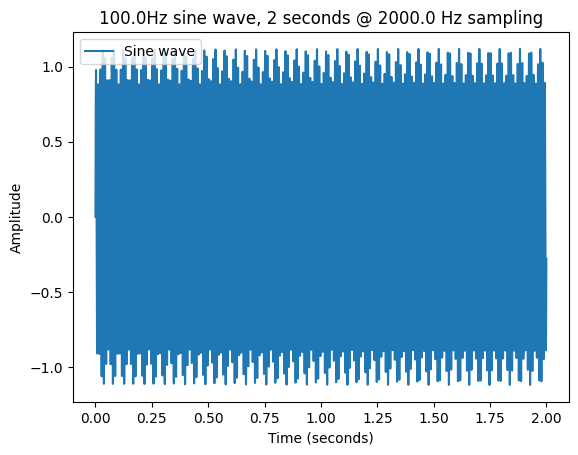

Phase 1: Embedding network training ...
 Step 50/100 | E_loss: 2.8106
 Step 100/100 | E_loss: 0.4514
Reconstruction error after Phase 1: 0.0020211274


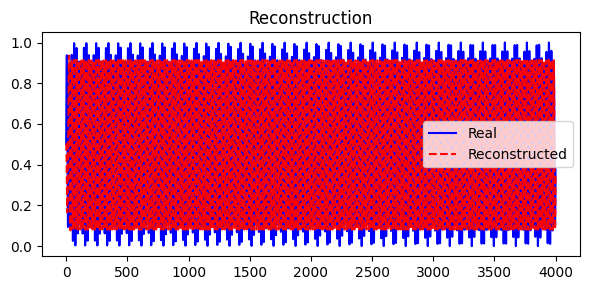

Phase 2: Supervised loss training ...


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['generator_3/lstm_48/lstm_cell/kernel', 'generator_3/lstm_48/lstm_cell/recurrent_kernel', 'generator_3/lstm_48/lstm_cell/bias', 'generator_3/lstm_49/lstm_cell/kernel', 'generator_3/lstm_49/lstm_cell/recurrent_kernel', 'generator_3/lstm_49/lstm_cell/bias', 'generator_3/lstm_50/lstm_cell/kernel', 'generator_3/lstm_50/lstm_cell/recurrent_kernel', 'generator_3/lstm_50/lstm_cell/bias', 'generator_3/dense_25/kernel', 'generator_3/dense_25/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


 Step 50/100 | S_loss: 0.0404
 Step 100/100 | S_loss: 0.0369
Supervisor next-step error after Phase 2: 0.03683082
Phase 3: Joint training (2 G updates, 1 D update per iteration) ...


In [ ]:
###############################################################################
# 8) Runs the TimeGAN
###############################################################################
if __name__ == "__main__":
    print("Running TimeGAN TF2 with sub-network pre-building ...")
    ori_data, gen_data, disc_score, pred_score = run_timegan_tf2_sine(
        n_samples=100,
        seq_len=2,
        base_freq=1e2,
        sampling_rate=2e3,
        dim=1,
        hidden_dim=32,
        num_layers=3,
        module='lstm', # lstm or gru
        gamma=1.0,
        iterations=100,
        batch_size=32,
        metric_iterations=1,
        patience=32,
        modulation='AM' # FM, AM, or both
    )

    print("Done!")